### Simple-to-Advance PDF parsing with easyparser

##### Simple PDF loading with easyparser

In [1]:
from pathlib import Path
pdf_path = str(Path.cwd().parent / "tests" / "assets" / "long.pdf")

In [2]:
from easyparser.controller import Controller
from easyparser.parser.pdf import FastPDF
from easyparser.base import CType

# load the PDF file with easyparser
root = Controller().as_root_chunk(pdf_path)
chunks = FastPDF.run(
    root, 
    use_layout_parser=True,
)
root_chunk = chunks[0]

# print the chunks graph
# the output is a tree structure
# with the root chunk at the top and the child chunks below
# the root chunk is the PDF file itself
root_chunk.print_graph()

# iterate throught the first root chunk (represent the PDF file)
# to get the child chunks as flattened list
child_chunks = [c for _, c in root_chunk.walk() if c.ctype != CType.Root]
print(f"Extracted {len(child_chunks)} chunks in the PDF file")

2025-05-22 16:22:51,631 - DownloadModel - INFO: /Users/taprosoft/miniconda3/lib/python3.12/site-packages/rapid_layout/models/yolov8n_layout_general6.onnx already exists
2025-05-22 16:22:51,661 - rapid_layout - INFO: yolov8n_layout_general6 contains ['Text', 'Title', 'Figure', 'Table', 'Caption', 'Equation']


 Chunk(id=a67e1, ctype=root, origin=/Users/taprosoft/Shared/debug/chunking/tests/assets/long.pdf)
     Chunk(id=039f2, ctype=figure, mimetype=image/png)
     Chunk(id=049e5, ctype=header, content=DeepSeek-V3 Technical Report)
     Chunk(id=53f1f, ctype=para, content=DeepSeek-AI)
     Chunk(id=ae1fa, ctype=para, content=research@deepseek.com)
     Chunk(id=31518, ctype=header, content=Abstract)
     Chunk(id=c109b, ctype=para, content=We present DeepSeek-V3, a strong Mixture-of-Expert... (142 more words))
     Chunk(id=a46e8, ctype=figure, mimetype=image/png)
     Chunk(id=bdc4d, ctype=para, content=Figure 1 | Benchmark performance of DeepSeek-V3 and its counterparts.)
     Chunk(id=04df5, ctype=para, content=arXiv:2412.19437v1 [cs.CL] 27 Dec 2024)
     Chunk(id=0fa73, ctype=header, content=Contents)
     Chunk(id=11459, ctype=para, content=**1 Introduction 4**)
     Chunk(id=47478, ctype=table, mimetype=image/png)
     Chunk(id=4e230, ctype=para, content=4.5.2 Ablation Studies for the 

##### Table-of-Content extraction
Alongside the elements from PDF, we can also extract the Table-of-Content to aid contextual information during RAG indexing process

In [3]:
from easyparser.split.toc_builder import TOCExtractor

# specify the LLM model name to use for TOC extraction
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key"
model = "gemini-2.5-flash-preview-04-17"

# if the PDF metadata has TOC information, it will be pulled directly
# if not, the TOC will be extracted using the LLM based on the headers
chunks = TOCExtractor.run(chunks, model=model, use_llm=True)

# print the chunks graph
print(chunks[0].render())
# in the sample PDF, TOC is available in the metadata 
# so extraction is fast and does not use LLM
# you can try other PDF files to see the LLM in action

# Introduction
# Architecture
## Basic Architecture
### Multi-Head Latent Attention
### DeepSeekMoE with Auxiliary-Loss-Free Load Balancing
## Multi-Token Prediction
# Infrastructures
## Compute Clusters
## Training Framework
### DualPipe and Computation-Communication Overlap
### Efficient Implementation of Cross-Node All-to-All Communication
### Extremely Memory Saving with Minimal Overhead
## FP8 Training
### Mixed Precision Framework
### Improved Precision from Quantization and Multiplication
### Low-Precision Storage and Communication
## Inference and Deployment
### Prefilling
### Decoding
## Suggestions on Hardware Design
### Communication Hardware
### Compute Hardware
# Pre-Training
## Data Construction
## Hyper-Parameters
## Long Context Extension
## Evaluations
### Evaluation Benchmarks
### Evaluation Results
## Discussion
### Ablation Studies for Multi-Token Prediction
### Ablation Studies for the Auxiliary-Loss-Free Balancing Strategy
### Batch-Wise Load Balance VS. Sequence-

##### Plot the output

Returned elements from easyparser PDF parsers contain metadata about its type, position and page number

To plot the elements on the original PDF to understand how the PDF file is read, you can add `debug_path` option

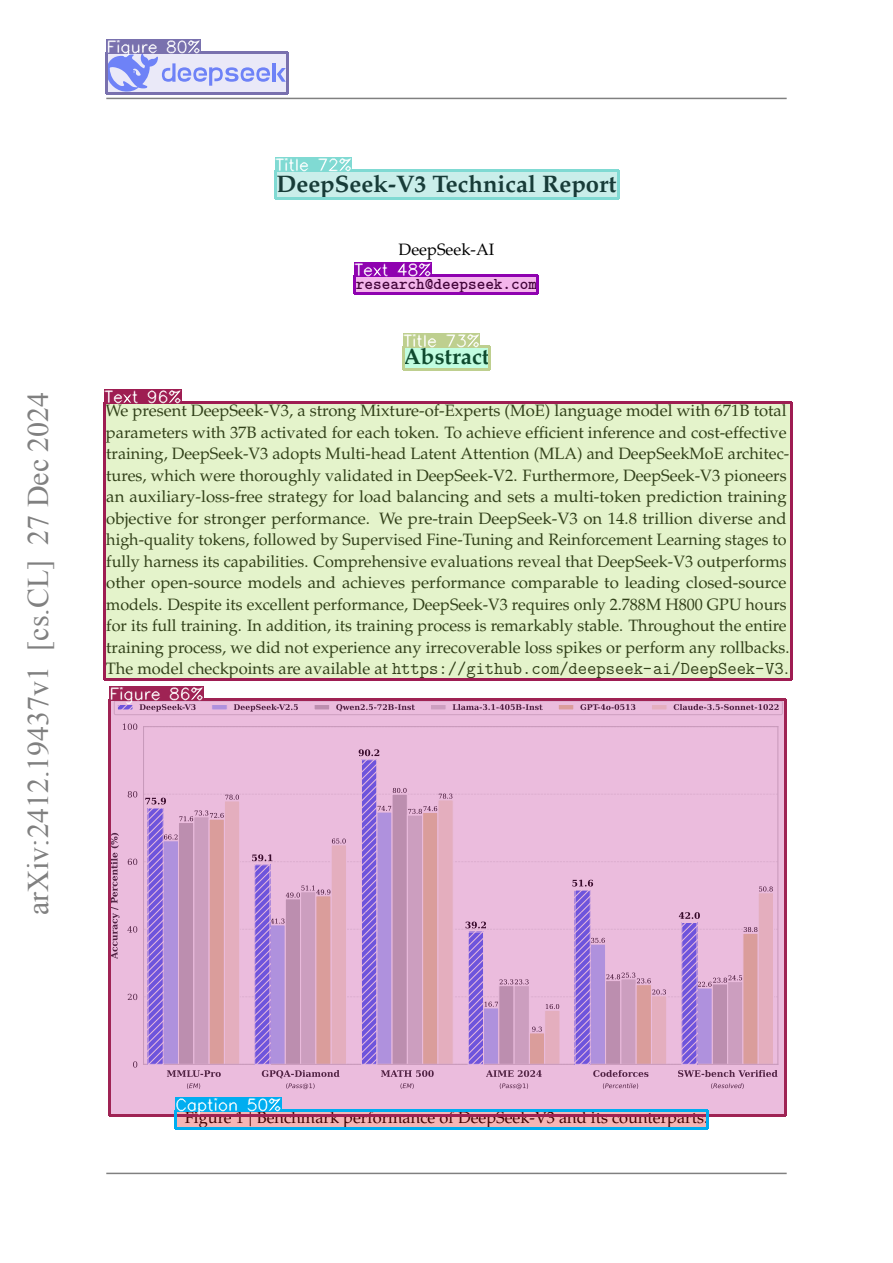

In [4]:
chunks = FastPDF.run(
    root, 
    use_layout_parser=True,
    debug_path="./debug"
)

# visualize the elements on page 0
from PIL import Image
image_path = "debug/layout_page_0.png"
Image.open(image_path)


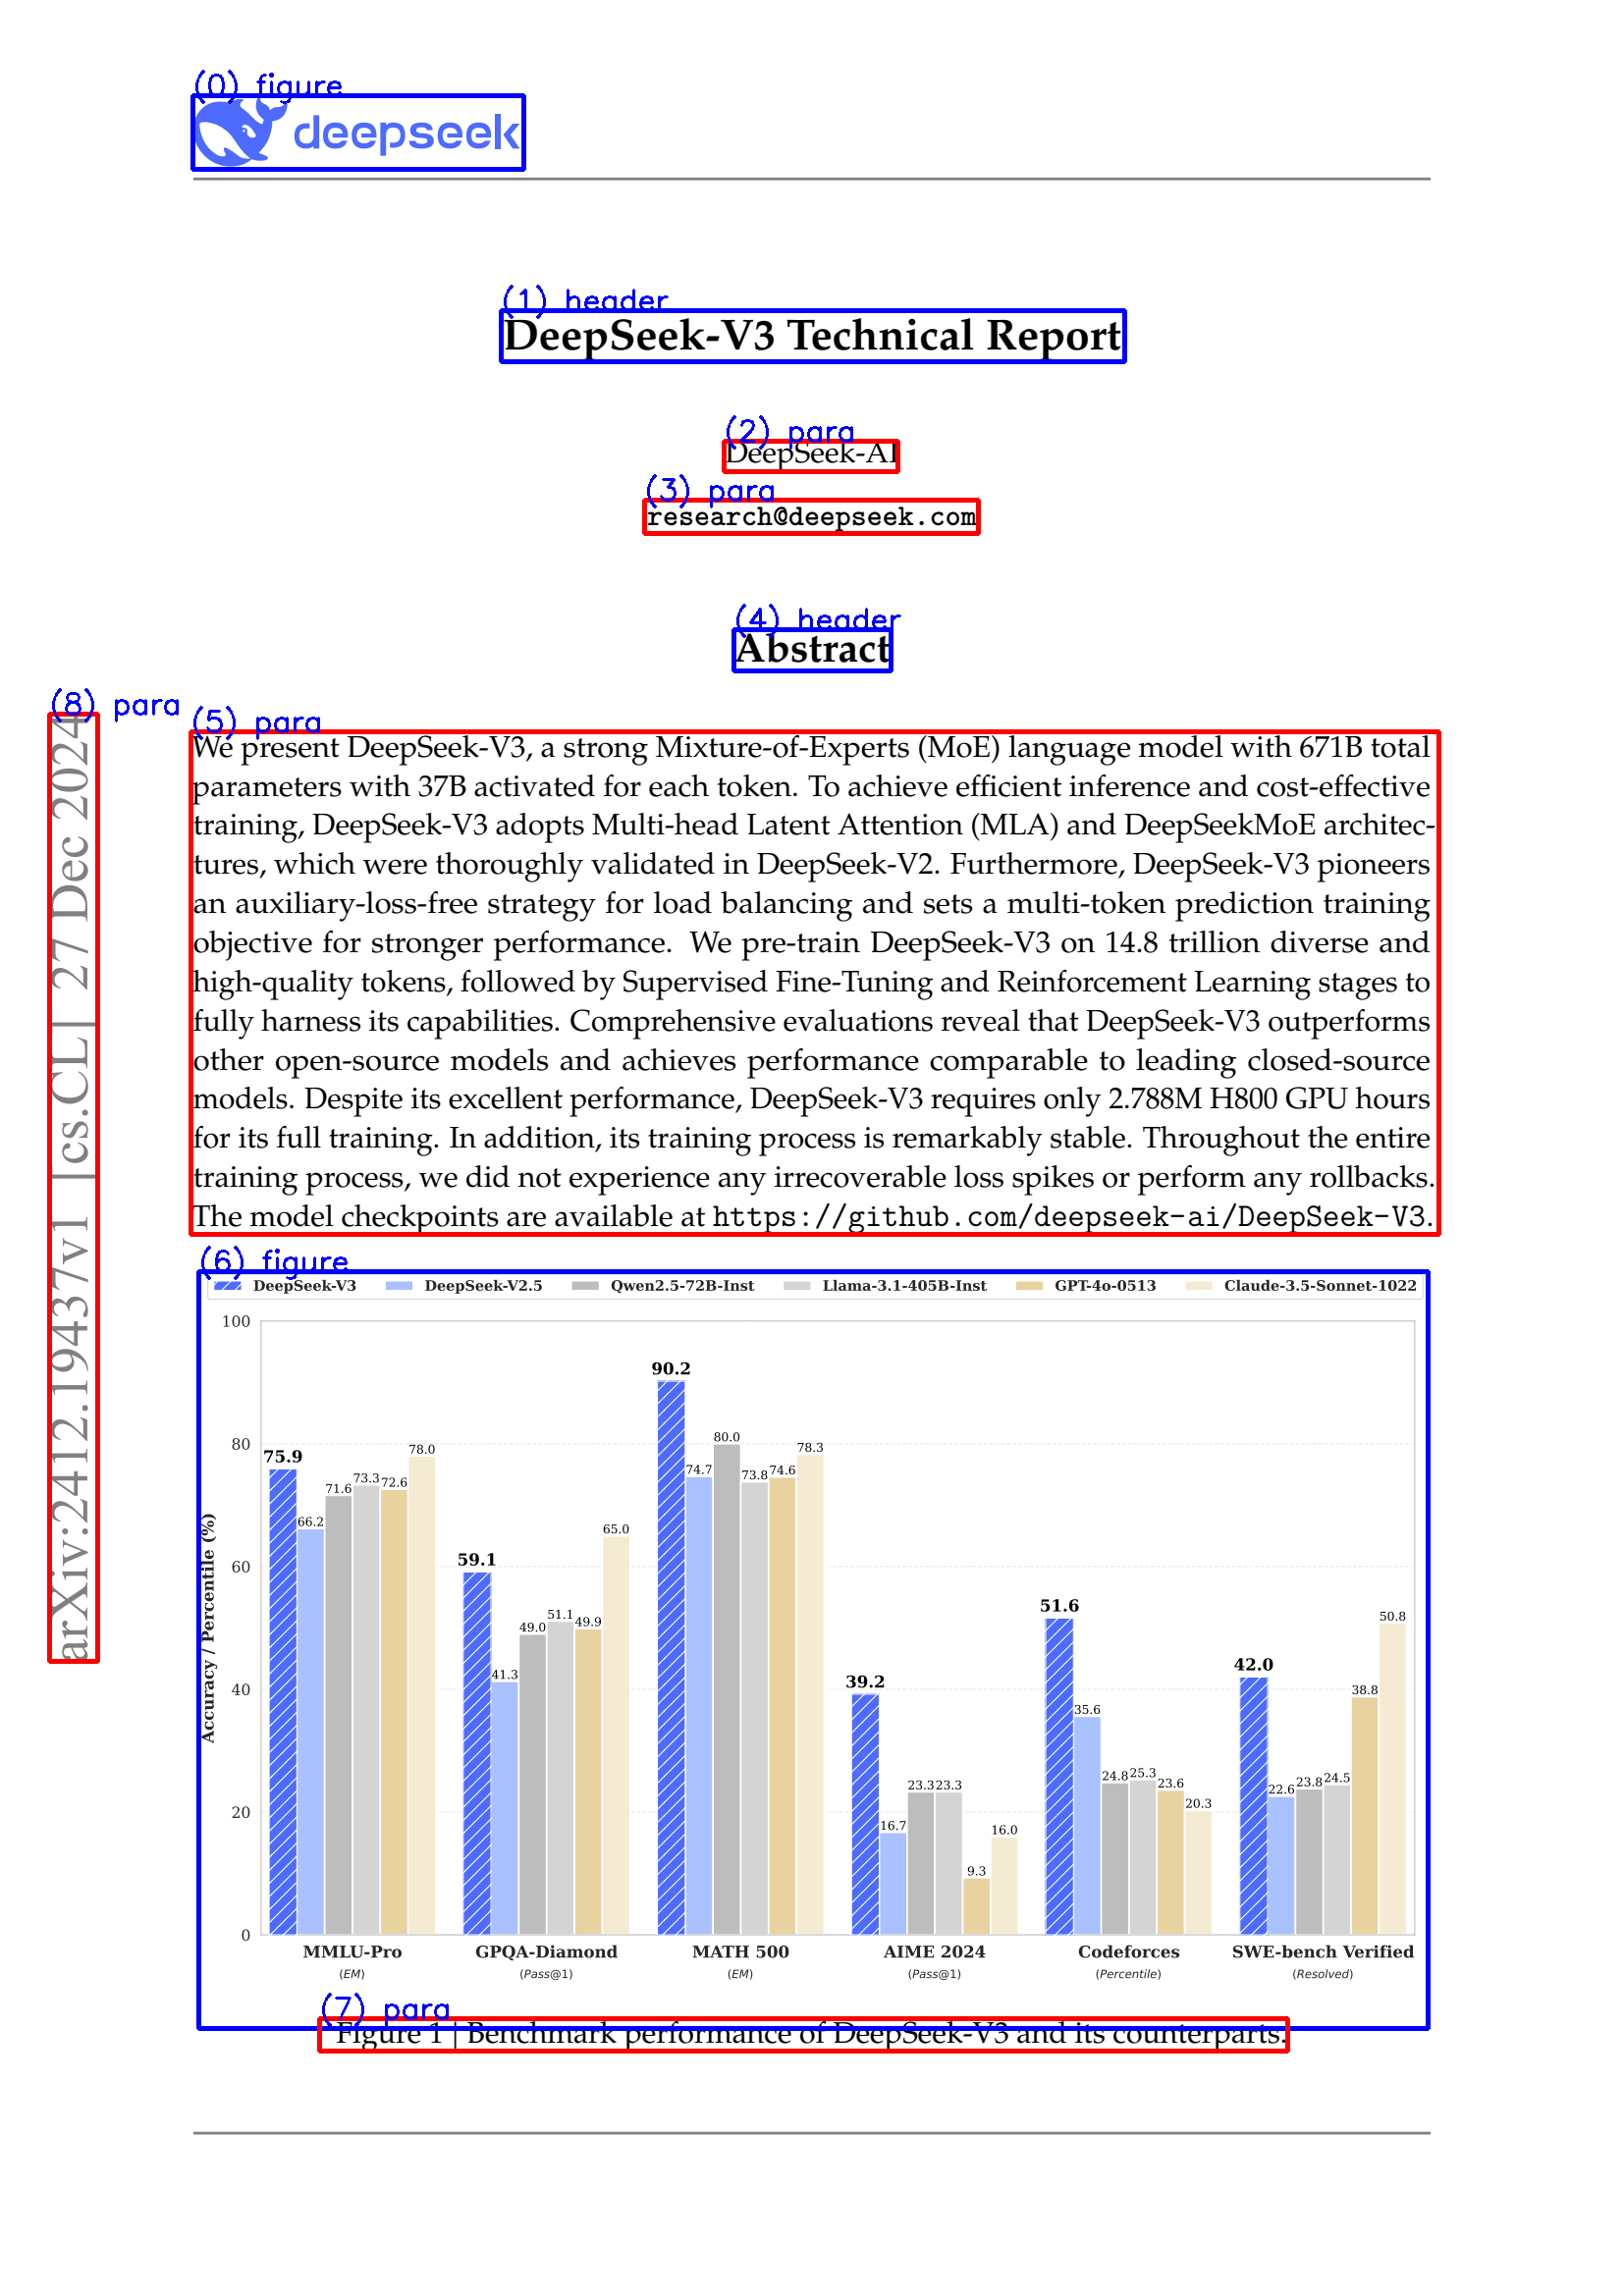

In [5]:
# or you can use the built-in plotting function with output chunks as parameter
from easyparser.util.plot import plot_pdf


plot_pdf(pdf_path, child_chunks, output_path="./debug")

image_path = "debug/page_0.png"
Image.open(image_path)

##### Get Sections information from PDF with TOC Hierarchy Builder

You already see that output of easyparser PDF parser is a tree structure. This is helpful if you want to organize and embed high-level semantic information of the document during a downstream RAG application.

The TOCHierarchyBuilder can be used for this purpose, which organize the chunks of the documents based on its headers hierarchy.

Let's see how it work.


In [6]:
from easyparser.split.toc_builder import TOCHierarchyBuilder

# specify the LLM model name to use for TOC building
# in this case you might have to setup GEMINI API key
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key"
model = "gemini-2.5-flash-preview-04-17"
chunks = TOCHierarchyBuilder.run(
    chunks,
    use_llm=True,
    model=model,
)
new_root = chunks[0]
new_root.print_graph()

# you can see the chunks are now organized in a tree structure
# with relevanat chunks in a section are grouped together under 
# the same parent header chunk

 Chunk(id=91bef, ctype=root, origin=/Users/taprosoft/Shared/debug/chunking/tests/assets/long.pdf)
     Chunk(id=06d28, ctype=figure, mimetype=image/png)
     Chunk(id=4d29f, ctype=para, content=DeepSeek-V3 Technical Report)
     Chunk(id=d9d45, ctype=para, content=DeepSeek-AI)
     Chunk(id=d4040, ctype=para, content=research@deepseek.com)
     Chunk(id=78fb6, ctype=header, content=Abstract)
         Chunk(id=4f1e4, ctype=para, content=We present DeepSeek-V3, a strong Mixture-of-Expert... (142 more words))
         Chunk(id=de144, ctype=figure, mimetype=image/png)
         Chunk(id=a3d89, ctype=para, content=Figure 1 | Benchmark performance of DeepSeek-V3 and its counterparts.)
         Chunk(id=e4d26, ctype=para, content=arXiv:2412.19437v1 [cs.CL] 27 Dec 2024)
     Chunk(id=a4a1f, ctype=header, content=Contents)
         Chunk(id=aa028, ctype=para, content=**1 Introduction 4**)
         Chunk(id=31d6c, ctype=table, mimetype=image/png)
         Chunk(id=e8958, ctype=para, content=4.5.2

In [7]:
# or just print the header chunks to understand the TOC structure
new_root.print_graph(ctype=CType.Header)

     Chunk(id=78fb6, ctype=header, content=Abstract)
     Chunk(id=a4a1f, ctype=header, content=Contents)
     Chunk(id=e3969, ctype=header, content=1. Introduction)
     Chunk(id=8996f, ctype=header, content=2. Architecture)
         Chunk(id=f7cce, ctype=header, content=2.1. Basic Architecture)
             Chunk(id=5f9cd, ctype=header, content=2.1.1. Multi-Head Latent Attention)
             Chunk(id=b76d0, ctype=header, content=2.1.2. DeepSeekMoE with Auxiliary-Loss-Free Load Balancing)
         Chunk(id=3a454, ctype=header, content=2.2. Multi-Token Prediction)
     Chunk(id=2a30a, ctype=header, content=3. Infrastructures)
         Chunk(id=60c76, ctype=header, content=3.1. Compute Clusters)
         Chunk(id=abb25, ctype=header, content=3.2. Training Framework)
             Chunk(id=9cc20, ctype=header, content=3.2.1. DualPipe and Computation-Communication Overlap)
             Chunk(id=13241, ctype=header, content=3.2.3. Extremely Memory Saving with Minimal Overhead)
         Chu

##### Multimodal parsing

The strong point of easyparser PDF Parser is its fast processing speed (even on CPU) while still provide multimodal structured elements.

You can see the content of Figure and Table elements in the chunking output in 2 formats, which retains most important information for RAG application during indexing:
- 2D Layout-preserving formatted text
- Cropped image of the original element

```table
               Benchmark    (Metric)         #  Shots  DeepSeek-V2      Qwen2.5    LLaMA-3.1     DeepSeek-V3
                                                            Base        72B  Base   405B  Base        Base

               Architecture                      -          MoE          Dense        Dense           MoE

               #  Activated  Params              -          21B            72B         405B            37B
               #  Total  Params                  -          236B           72B         405B           671B

               Pile-test (BPB)                   -          0.606         0.638        0.542          0.548

               BBH  (EM)                      3-shot        78.8          79.8         82.9           87.5
               MMLU    (EM)                   5-shot        78.4          85.0         84.4           87.1

               MMLU-Redux     (EM)            5-shot        75.6          83.2         81.3           86.2

               MMLU-

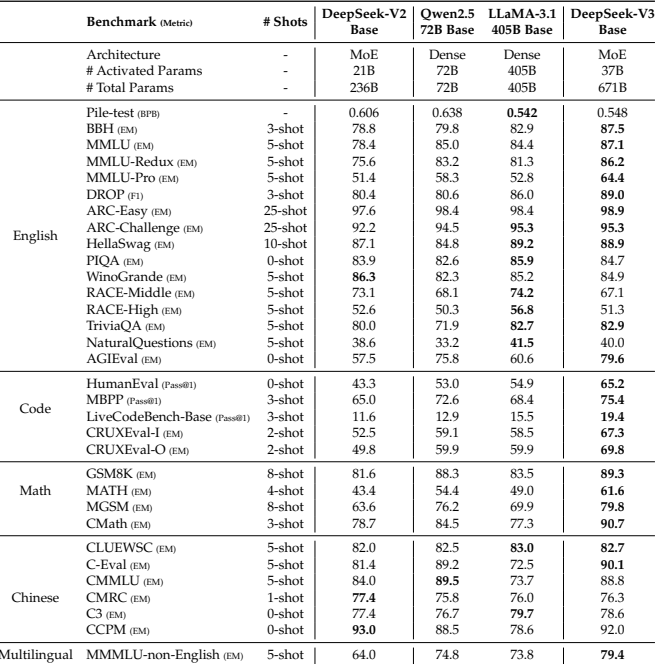

In [8]:
# get the target Table chunk
table_chunk = new_root.find_all(ctype=CType.Table)[4]

# show the 2D rendered text of the table chunk
print(table_chunk.text)

# see how it looks like in the PDF
print(table_chunk.mimetype)
# render the content (bytes) to a PIL Imagea
table_dict = table_chunk.render("multi")[0]
print(list(table_dict.keys()))
table_dict["content"]

```figure
                𝑡𝑡2  𝑡𝑡3  𝑡𝑡4  𝑡𝑡5                     𝑡𝑡3  𝑡𝑡4  𝑡𝑡5  𝑡𝑡6                    𝑡𝑡4  𝑡𝑡5  𝑡𝑡6  𝑡𝑡7
 Target  Tokens

                   Cross-Entropy  Loss                           Cross-Entropy  Loss                           Cross-Entropy  Loss
                                                                                           ℒMTP 1                                        ℒMTP 2
                                             ℒ𝑀𝑀𝑀𝑀𝑀𝑀𝑀𝑀
        Main  Model                                  MTP   Module  1
                                                     (Next2 Token  Prediction)                     MTP   Module  2
                                                                                                   (Next3 Token  Prediction)
        (Next  Token  Prediction)
                     Output  Head                                   Output  Head
                                              Shared                                                       

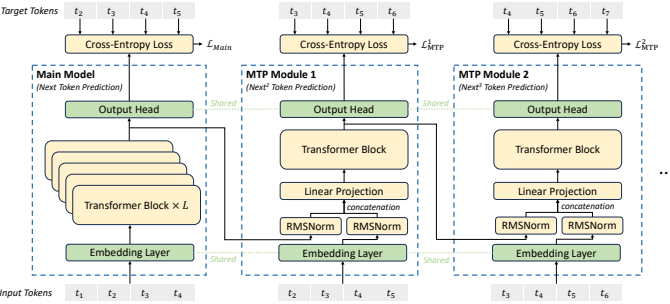

In [9]:
# we can do the same for Figure chunk
figure_chunk = new_root.find_all(ctype=CType.Figure)[3]

# show the 2D rendered text of the table chunk
print(figure_chunk.text)

# see how it looks like in the PDF
print(figure_chunk.mimetype)
# render the content (bytes) to a PIL Imagea
figure_dict = figure_chunk.render("multi")[0]
print(list(figure_dict.keys()))
figure_dict["content"]

##### Speed benchmarking

easyparser PDF Parser is fast! You can compare the processing time of easyparser PDF Parser with PyMuPDF4LLM, which is a well-known solution and also perform very good on CPU.

Note that PyMuPDF4LLM is limited with metadata-embedded PDF. It does not do automated OCR, perform borderless table extraction or extracting figures that are not just raw image from the PDF file.

In [10]:
import time

pdf_path = str(Path.cwd().parent / "tests" / "assets" / "long.pdf")
start_time = time.time()
# process with easyparser
chunks = FastPDF.run(
    root, 
    use_layout_parser=True,
)
elapsed_time = time.time() - start_time
num_pages = max(
    chunk.origin.location["page"] for _, chunk in chunks[0].walk()
    if chunk.ctype != CType.Root
) 

print(f"Processing time with easyparser: {elapsed_time:.2f} seconds. Avg time per page: {elapsed_time / num_pages:.2f} seconds")

# process with PyMuPDF
# need to install `pip install pymupdf4llm`
import pymupdf4llm
start_time = time.time()
text = pymupdf4llm.to_markdown(pdf_path)
elapsed_time = time.time() - start_time
print(f"Processing time with PyMuPDF4LLM: {elapsed_time:.2f} seconds. Avg time per page: {elapsed_time / num_pages:.2f} seconds")

Processing time with easyparser: 7.28 seconds. Avg time per page: 0.14 seconds
Processing time with PyMuPDF4LLM: 88.85 seconds. Avg time per page: 1.68 seconds


##### Switching modes

easyparser PDF Parser support several quick presets which can be beneficial based on your application demand to balance between latency and accuracy.

In [ ]:
from easyparser.parser.pdf import ParserPreset

parser_preset = ParserPreset.BEST # pick betweens: BEST, BEST_NO_OCR, FAST, FAST_2D

# let's see how each of them performs
start_time = time.time()
root = Controller().as_root_chunk(pdf_path)
chunks = FastPDF.run(
    root, 
    preset=ParserPreset.BEST,
)
# this is the default preset with best quality output, including OCR, Layout Analysis, and 2D text rendering
elapsed_time = time.time() - start_time
print(f"Processing time with BEST preset: {elapsed_time:.2f} seconds.")

start_time = time.time()
root = Controller().as_root_chunk(pdf_path)
chunks = FastPDF.run(
    root, 
    preset=ParserPreset.FAST,
)
# this is the FAST preset with heuristic-based text extraction from the PDF file
# no OCR or Layout Analysis is performed
# the main advantage is that it is very fast
elapsed_time = time.time() - start_time
print(f"Processing time with FAST preset: {elapsed_time:.2f} seconds.")

start_time = time.time()
root = Controller().as_root_chunk(pdf_path)
chunks = FastPDF.run(
    root, 
    preset=ParserPreset.FAST_2D,
)
# in another ground we have FAST_2D preset which render the whole page from 
# the PDF file as 2D text (preserve semantic information of original page layout)
# this text can be later sent to LLM for correct reading order serialization
# or table extraction
elapsed_time = time.time() - start_time
print(f"Processing time with FAST_2D preset: {elapsed_time:.2f} seconds.")

# example output of the FAST_2D preset
first_child_chunk = chunks[0]
first_child_chunk.print_graph()

# print the first page chunk
print(first_child_chunk.child)
print("Content of page 1:")
print(first_child_chunk.child.content)

Processing time with BEST preset: 8.69 seconds.
Processing time with FAST preset: 4.46 seconds.
Processing time with FAST_2D preset: 3.11 seconds.
 Chunk(id=a67e1, ctype=root, origin=/Users/taprosoft/Shared/debug/chunking/tests/assets/long.pdf)
     Chunk(id=7e2cf, ctype=para, content=```page                                         De... (244 more words))
     Chunk(id=e98c0, ctype=para, content=```page  Contents    1  Introduction              ... (917 more words))
     Chunk(id=a8711, ctype=para, content=```page            4.5.3     Batch-Wise     Load  ... (570 more words))
     Chunk(id=44f43, ctype=para, content=```page  1. Introduction   In recent years, Large ... (589 more words))
     Chunk(id=0909c, ctype=para, content=```page      Training   Costs         Pre-Training... (466 more words))
     Chunk(id=0dc32, ctype=para, content=```page       verification  and  reflection patter... (457 more words))
     Chunk(id=bd571, ctype=para, content=```page                             

##### That's it!

You can check out other tutorials: using easyparser for LlamaIndex RAG integration or Contextual Embedding in other notebooks in this same directory.